In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models,layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_roc_curve


2023-04-15 20:52:35.203538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-15 20:52:35.203603: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
image_size = 256
batch_size = 32
channels = 3
epochs = 55


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('datasetFd',
                                                              shuffle=True,
                                                              image_size=(image_size,image_size),
                                                              batch_size=batch_size)

Found 2545 files belonging to 8 classes.


2023-04-15 20:52:48.961412: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-15 20:52:48.961487: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-15 20:52:48.961775: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: GiBiO
2023-04-15 20:52:48.961812: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: GiBiO
2023-04-15 20:52:48.962052: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: Not found: was unable to find libcuda.so DSO loaded into this program
2023-04-15 20:52:48.962746: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.105.1
2023-04-15 20:52:48.964683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow bi

In [5]:
class_names = dataset.class_names
print(class_names)


['Byen', 'Foli', 'Koi', 'Sing', 'Sol', 'Sorputi', 'Taki', 'Tengra']


In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

2023-04-15 20:52:51.552322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-15 20:52:51.553537: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz


(32, 256, 256, 3)
[0 2 4 6 6 0 2 0 6 0 1 0 3 7 0 3 7 4 3 7 6 2 3 0 2 5 0 1 0 7 0 3]


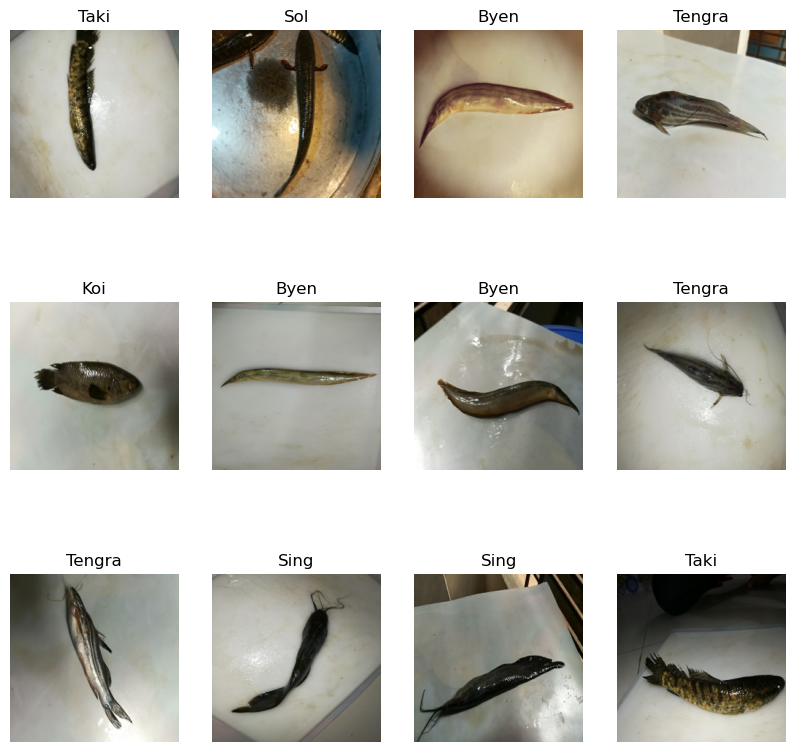

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.title(class_names[label_batch[i]])
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    print(ds_size)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    print(train_size)
    val_size = int(val_split * ds_size)
    print(train_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


80
64
64


In [10]:
for image_batch, labels_batch in test_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[3 2 7 1 6 7 3 6 0 0 0 6 7 0 3 3 7 5 2 2 2 2 1 0 7 3 6 1 0 7 2 7]


In [11]:
for image_batch, labels_batch in val_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 2 0 0 5 6 0 3 7 6 1 7 3 1 4 0 2 3 1 0 6 6 6 2 0 3 0 1 0 6 3 1]


In [12]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[7 3 2 2 6 0 2 0 5 2 2 6 3 6 0 1 1 0 0 7 0 1 2 0 2 2 7 4 0 3 0 1]


In [13]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:

input_shape = (batch_size, image_size, image_size, channels)
n_classes = 8
model = models.Sequential([
    resize_rescaling,
    data_augmentation,
    layers.Conv2D(64,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    


])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (32, 254, 254, 64)        1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (32, 127, 127, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (32, 125, 125, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (32, 60, 60, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size = batch_size,
    verbose=1,
    validation_data = val_ds

)

Epoch 1/55


2023-04-15 20:55:15.564839: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 528515072 exceeds 10% of free system memory.
2023-04-15 20:55:16.067117: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 132128768 exceeds 10% of free system memory.
2023-04-15 20:55:16.230126: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 128000000 exceeds 10% of free system memory.
2023-04-15 20:55:17.432619: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 128000000 exceeds 10% of free system memory.
2023-04-15 20:55:17.676953: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 132128768 exceeds 10% of free system memory.


64/64 [==============================] - 219s 3s/step - loss: 1.9700 - accuracy: 0.2100 - val_loss: 1.7418 - val_accuracy: 0.3154
Epoch 2/55
64/64 [==============================] - 236s 4s/step - loss: 1.5767 - accuracy: 0.3645 - val_loss: 1.4029 - val_accuracy: 0.4440
Epoch 3/55
64/64 [==============================] - 238s 4s/step - loss: 1.3611 - accuracy: 0.4432 - val_loss: 1.6223 - val_accuracy: 0.3444
Epoch 4/55
64/64 [==============================] - 250s 4s/step - loss: 1.2428 - accuracy: 0.4953 - val_loss: 1.1686 - val_accuracy: 0.4772
Epoch 5/55
64/64 [==============================] - 245s 4s/step - loss: 1.1965 - accuracy: 0.5253 - val_loss: 1.3150 - val_accuracy: 0.4813
Epoch 6/55
64/64 [==============================] - 238s 4s/step - loss: 1.0606 - accuracy: 0.5765 - val_loss: 1.0082 - val_accuracy: 0.6224
Epoch 7/55
64/64 [==============================] - 237s 4s/step - loss: 0.9863 - accuracy: 0.6139 - val_loss: 0.9580 - val_accuracy: 0.5768
Epoch 8/55
64/64 [======

In [24]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 13s 836ms/step - loss: 0.1226 - accuracy: 0.9585


In [25]:
history.params

{'verbose': 1, 'epochs': 55, 'steps': 64}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['accuracy']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

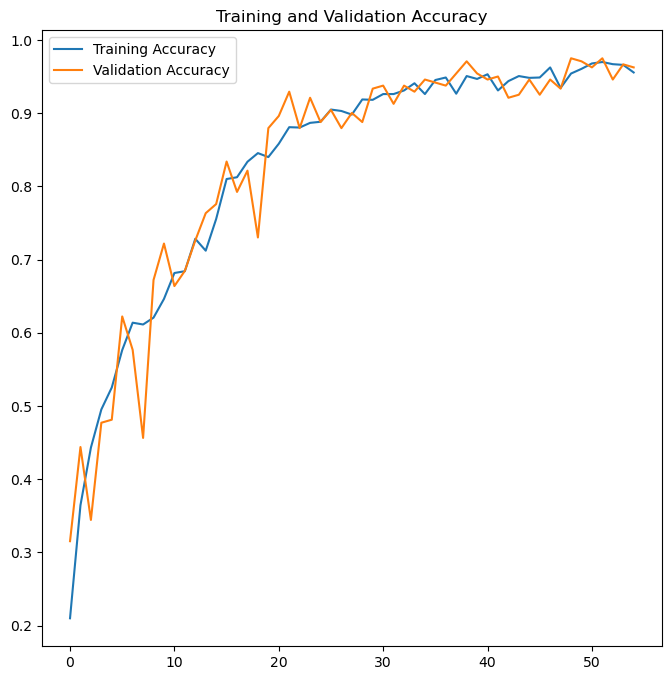

In [28]:
plt.figure(figsize=(8,8))

plt.plot(range(epochs),acc,label='Training Accuracy')
plt.plot(range(epochs),val_acc,label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

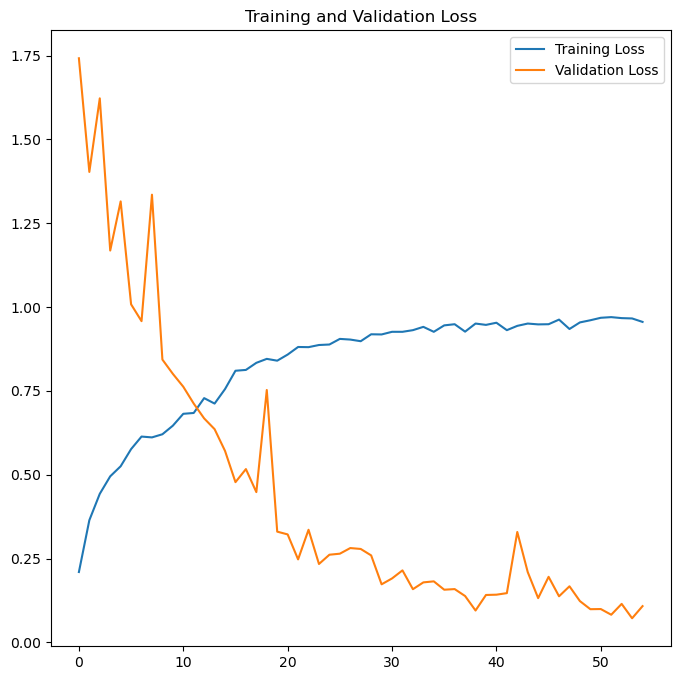

In [29]:
plt.figure(figsize=(8,8))
plt.plot(range(epochs),loss,label='Training Loss')
plt.plot(range(epochs),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

First Image to Predict
First image's actual label :  Sorputi
Predicted Label :  Sorputi


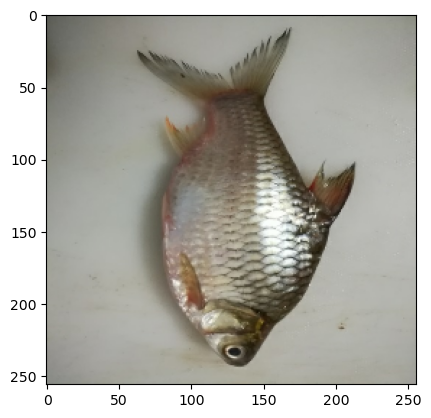

In [30]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict")
    plt.imshow(first_image)
    print("First image's actual label : ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label : ",class_names[np.argmax(batch_prediction[0])])
    


In [31]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class,confidence

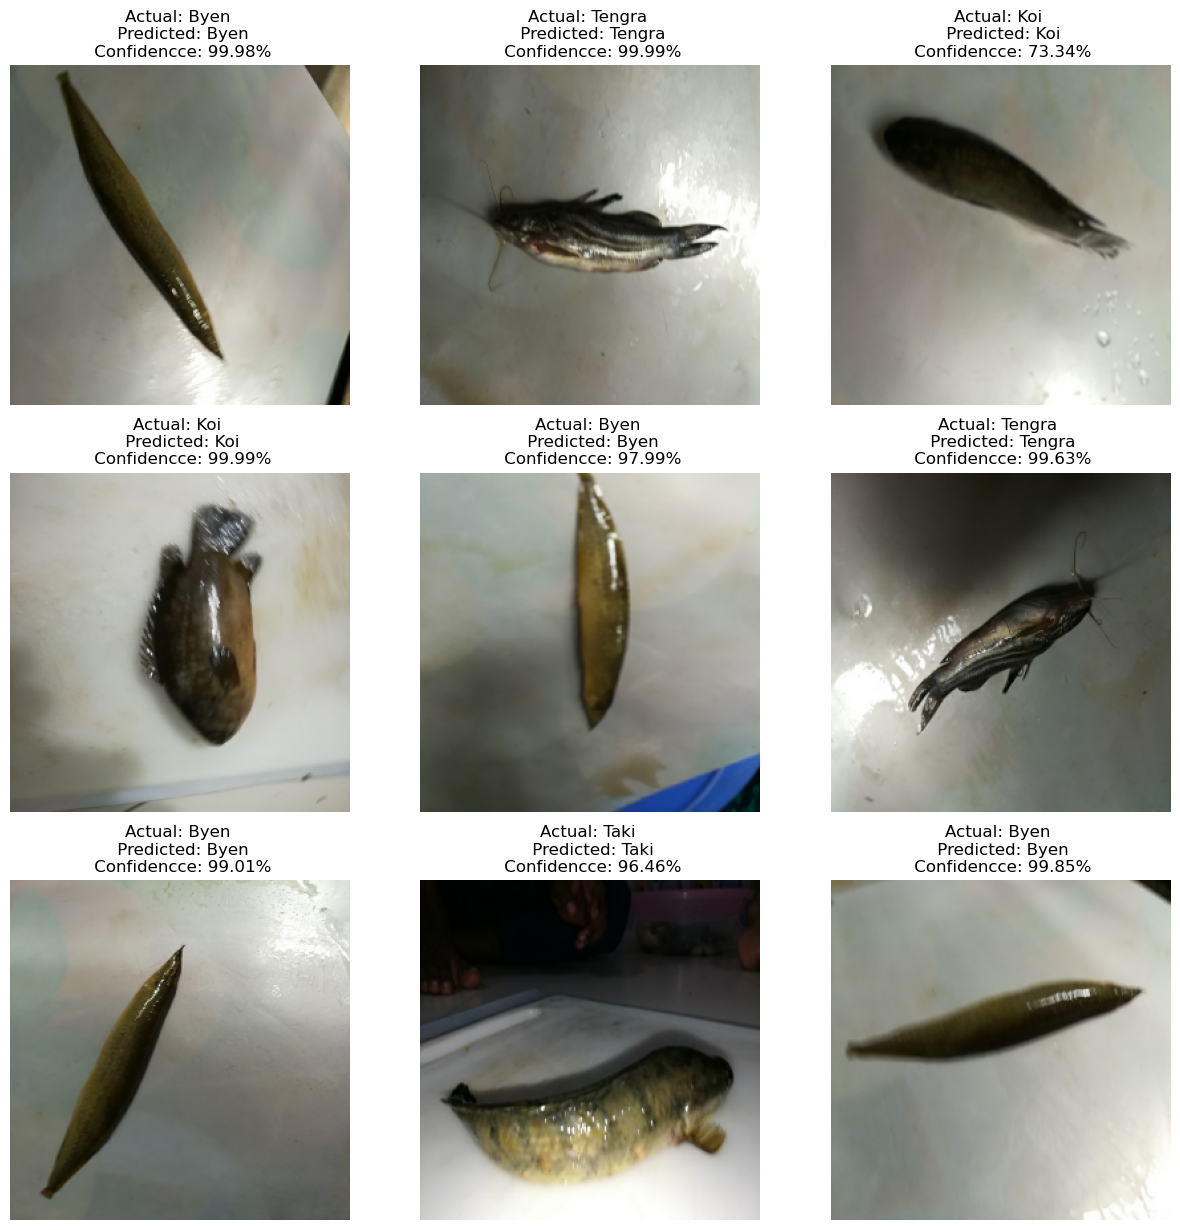

In [32]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class}\n Confidencce: {confidence}%")
        plt.axis("off")

In [36]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models")+[0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2/assets


In [37]:
model.save("../fd.h5")